## Introduction

#### Machine Learning model to predict the weekly dispatch count of the warehouse based on the different warehouses' product-wise daily dispatch data.

### Import the necessary packages.

In [2]:
!pip install -q klib

     |████████████████████████████████| 132 kB 17.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization
from matplotlib import pyplot as plt # visualization
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import re
import klib

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Import train and test dataset

In [5]:
train=pd.read_csv("/content/gdrive/MyDrive/HE_tredence-data-scientist-hiring-challenge_2022/train.csv")
test=pd.read_csv("/content/gdrive/MyDrive/HE_tredence-data-scientist-hiring-challenge_2022/test.csv")

### Change column names in train and test dataset to lowercase.

In [6]:
train=train.rename(columns={col:col.lower() for col in train.columns.values})
test=test.rename(columns={col:col.lower() for col in test.columns.values})

### Structure of the train and test dataset.

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16644 entries, 0 to 16643
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     16644 non-null  object 
 1   date                   16644 non-null  object 
 2   warehouse_id           16644 non-null  object 
 3   latitude               16312 non-null  float64
 4   longitude              16228 non-null  float64
 5   product_type           16644 non-null  object 
 6   year                   16644 non-null  int64  
 7   month                  16644 non-null  object 
 8   is_weekend             16145 non-null  object 
 9   is_warehouse_closed    16478 non-null  object 
 10  daily_dispatch_count   16644 non-null  float64
 11  weekly_dispatch_count  2372 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 1.5+ MB


#### The above information shows that there are 16644 data entries and 12 columns.

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4900 entries, 0 to 4899
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   4900 non-null   object 
 1   date                 4900 non-null   object 
 2   warehouse_id         4900 non-null   object 
 3   latitude             4802 non-null   float64
 4   longitude            4778 non-null   float64
 5   product_type         4900 non-null   object 
 6   year                 4900 non-null   int64  
 7   month                4900 non-null   object 
 8   is_weekend           4753 non-null   object 
 9   is_warehouse_closed  4851 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 382.9+ KB


#### The above information shows that there are 4900 data entries and 10 columns.

#### Let's see is there any missing values in train and test dataset by column wise.

In [ ]:
train.isnull().sum()

id                           0
date                         0
warehouse_id                 0
latitude                   332
longitude                  416
product_type                 0
year                         0
month                        0
is_weekend                 499
is_warehouse_closed        166
daily_dispatch_count         0
weekly_dispatch_count    14272
dtype: int64

In [ ]:
train.columns[train.isnull().any()]

Index(['latitude', 'longitude', 'is_weekend', 'is_warehouse_closed',
       'weekly_dispatch_count'],
      dtype='object')

#### The above information shows that there are missing values in the latitude, longitude, is_weekend, is_warehouse_closed, weekly_dispatch_count.

In [ ]:
test.isnull().sum()

id                       0
date                     0
warehouse_id             0
latitude                98
longitude              122
product_type             0
year                     0
month                    0
is_weekend             147
is_warehouse_closed     49
dtype: int64

In [ ]:
test.columns[test.isnull().any()]

Index(['latitude', 'longitude', 'is_weekend', 'is_warehouse_closed'], dtype='object')

#### The above information shows that there are missing values in the latitude, longitude, is_weekend, is_warehouse_closed

#### Let's see the glimpse of train dataset

In [ ]:
train.head(2)

,id,date,warehouse_id,latitude,longitude,product_type,year,month,is_weekend,is_warehouse_closed,daily_dispatch_count,weekly_dispatch_count
0,0x2710,2017-01-01,WH_0x3e9,41.681471,-72.794746,Type_A,2017,January,Yes,No,5.5,5.5
1,0x33e6,2017-01-01,WH_0x3ea,38.749077,-105.183060,Type_A,2017,January,Yes,No,6.1,6.1


### Let's create a function for count plot(for categorical data).

In [ ]:
def count_plot(df,col,rot=None):
  _=plt.figure(figsize=(8,6))
  _=sns.countplot(x=df[col],order=df[col].value_counts().index)
  _=plt.title(col.capitalize()+" Distribution",fontsize=25)
  _=plt.xlabel(col,fontsize=20)
  _=plt.xticks(fontsize=14,rotation=rot)

### Let's create a function for box plot.

In [ ]:
def box_plot(df,col,rot=None):
  _=plt.figure(figsize=(8,6))
  _=sns.boxplot(y=df[col])
  _=plt.title(col.capitalize()+" Distribution",fontsize=25)
  _=plt.ylabel(col,fontsize=20,rotation=rot)
  _=plt.yticks(fontsize=14)


### Let's create a function for side by side plot(density and group-wise boxplot).

In [ ]:
def side_by_side_plot(df,grp,valcol,rot=None):
  clr="tab10"
  fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,8))
  fig.tight_layout()
  sns.kdeplot(x=df[valcol], hue=df[grp],ax=ax1,palette=clr)
  ax1.set_title(grp.capitalize()+" Wise "+valcol.capitalize()+" Distribution",size=15)
  ax1.set_xlabel(valcol,fontsize=20)
  sns.boxplot(x=df[grp],y=df[valcol],ax=ax2)
  ax2.set_title(grp.capitalize()+" Wise "+valcol.capitalize()+" Distribution",size=15)
  ax2.set_xlabel(grp,fontsize=20)
  ax2.tick_params(rotation=rot)

### Let's create a function for group by numerical summary.

In [ ]:
def group_summary(df,groupcol,value):
    return df.groupby(groupcol)[value].describe().reset_index().sort_values('mean',ascending=False)

### Let's see the weekly_dispatch_count column distribution.

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


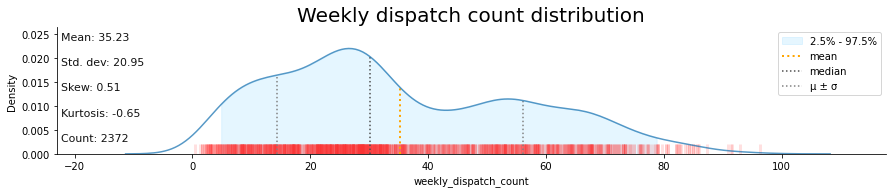

In [ ]:
klib.dist_plot(train['weekly_dispatch_count']);
plt.title("weekly dispatch count distribution".capitalize(),fontsize=20);

In [ ]:
train['weekly_dispatch_count'].describe()

count    2372.000000
mean       35.233938
std        20.953378
min         0.000000
25%        19.475000
50%        30.100000
75%        52.000000
max        96.400000
Name: weekly_dispatch_count, dtype: float64

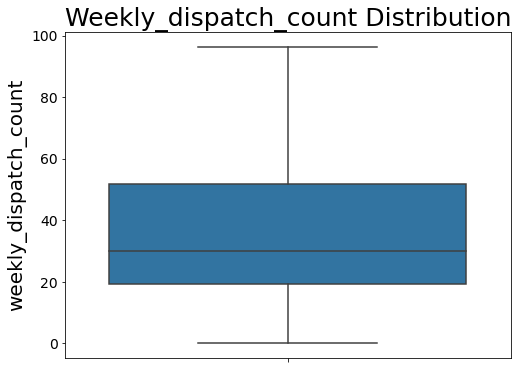

In [ ]:
box_plot(train,'weekly_dispatch_count',rot=90)

#### The above histogram explains that weekly_dispatch_count column is postively skewed. 

### The weekly_dispatch_count ranges from 0 to 96.

### The average weekly_dispatch_count value is 35.

#### The boxplot explains that there are no outliers.

### Let's see the daily_dispatch_count column distribution.

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


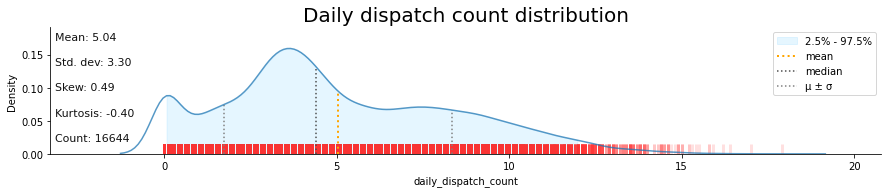

In [ ]:
klib.dist_plot(train['daily_dispatch_count']);
plt.title("daily dispatch count distribution".capitalize(),fontsize=20);

In [ ]:
train['daily_dispatch_count'].describe()

count    16644.000000
mean         5.042640
std          3.304978
min          0.000000
25%          2.800000
50%          4.400000
75%          7.500000
max         17.900000
Name: daily_dispatch_count, dtype: float64

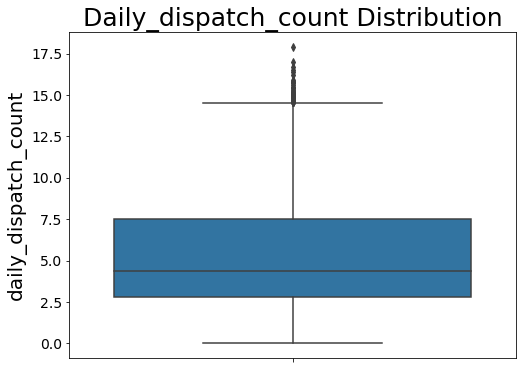

In [ ]:
box_plot(train,'daily_dispatch_count',rot=90)

#### The above histogram explains that daily_dispatch_count column is postively skewed. 

### The daily_dispatch_count ranges from 0 to 17.

### The average daily_dispatch_count value is 5.

#### The boxplot explains that there are outliers above the third quartile.

### Let's see various warehouses and their weekly dispatch count.

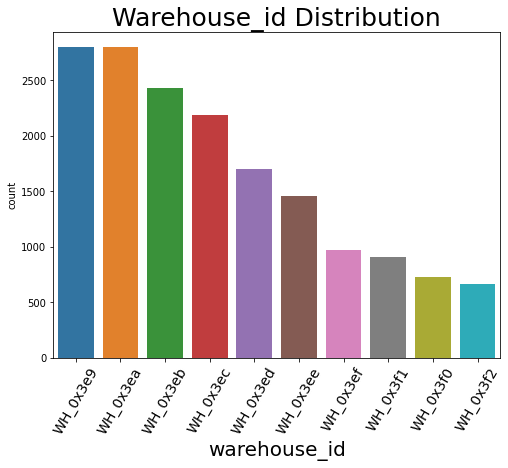

In [ ]:
count_plot(train,'warehouse_id',rot=60)

In [ ]:
train['warehouse_id'].value_counts()

WH_0x3e9    2796
WH_0x3ea    2796
WH_0x3eb    2430
WH_0x3ec    2190
WH_0x3ed    1700
WH_0x3ee    1460
WH_0x3ef     970
WH_0x3f1     908
WH_0x3f0     728
WH_0x3f2     666
Name: warehouse_id, dtype: int64

#### The above plot explains that the more number of dispatches from the warehouses WH_0x3e9W, H_0x3ea, WH_0x3eb, WH_0x3ec, WH_0x3ed, WH_0x3ee.

#### The warehouses WH_0x3e9 and WH_0x3ea have similar number of dispatches.

#### Let's see the weekly dispatch count  from each warehouse.

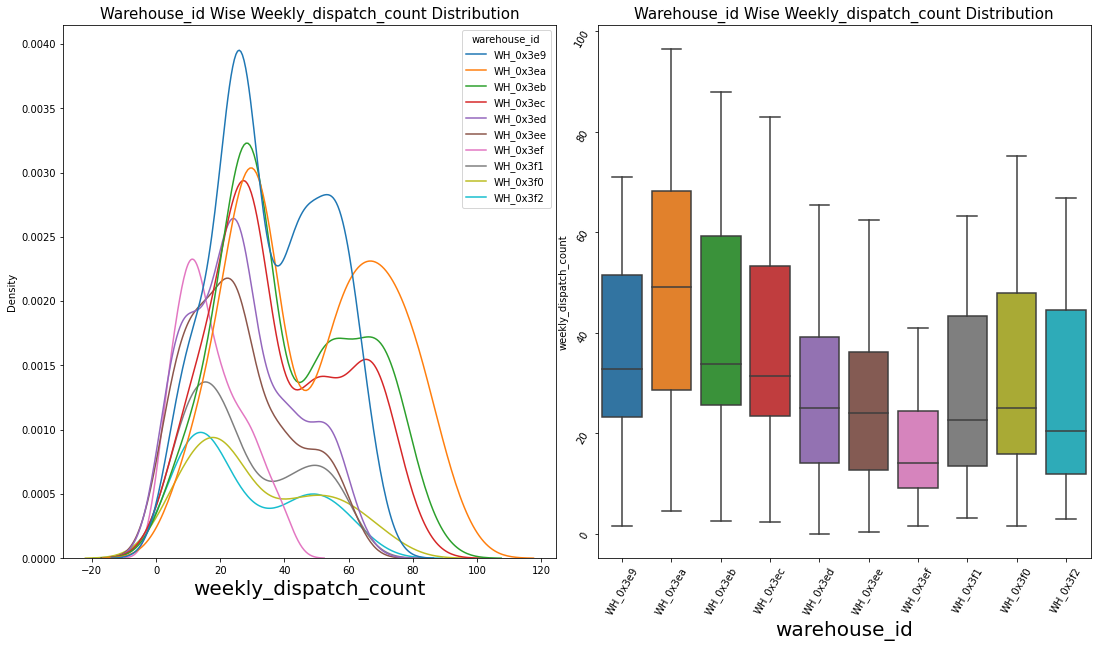

In [ ]:
side_by_side_plot(train,'warehouse_id','weekly_dispatch_count',rot=60)

In [ ]:
group_summary(train,'warehouse_id','weekly_dispatch_count')

,warehouse_id,count,mean,std,min,25%,50%,75%,max
1,WH_0x3ea,399.0,48.478697,23.391921,4.6,28.600,49.20,68.250,96.4
2,WH_0x3eb,346.0,41.447977,21.058125,2.6,25.600,33.70,59.225,87.9
3,WH_0x3ec,312.0,38.255449,20.397723,2.3,23.500,31.40,53.300,82.8
0,WH_0x3e9,399.0,36.071178,17.143349,1.6,23.250,32.80,51.400,70.9
7,WH_0x3f0,104.0,31.148077,19.920897,1.6,15.975,25.10,47.850,75.1
8,WH_0x3f1,130.0,27.663077,17.298847,3.2,13.600,22.70,43.300,63.3
9,WH_0x3f2,94.0,27.595745,18.512390,2.9,11.875,20.55,44.575,66.8
4,WH_0x3ed,242.0,26.812397,16.054728,0.0,14.125,25.05,39.075,65.4
5,WH_0x3ee,208.0,25.546154,15.847921,0.3,12.750,24.10,36.100,62.4
6,WH_0x3ef,138.0,16.891304,10.149334,1.6,9.125,14.10,24.450,41.0


#### The above plot explains that there is a difference in the weekly dispatch count between the warehouses.

#### Let's see the product types wise weekly dispatch count distribution.

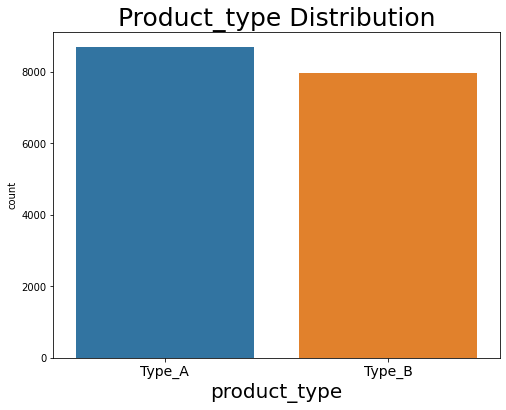

In [ ]:
count_plot(train,'product_type')

In [ ]:
train['product_type'].value_counts()

Type_A    8688
Type_B    7956
Name: product_type, dtype: int64

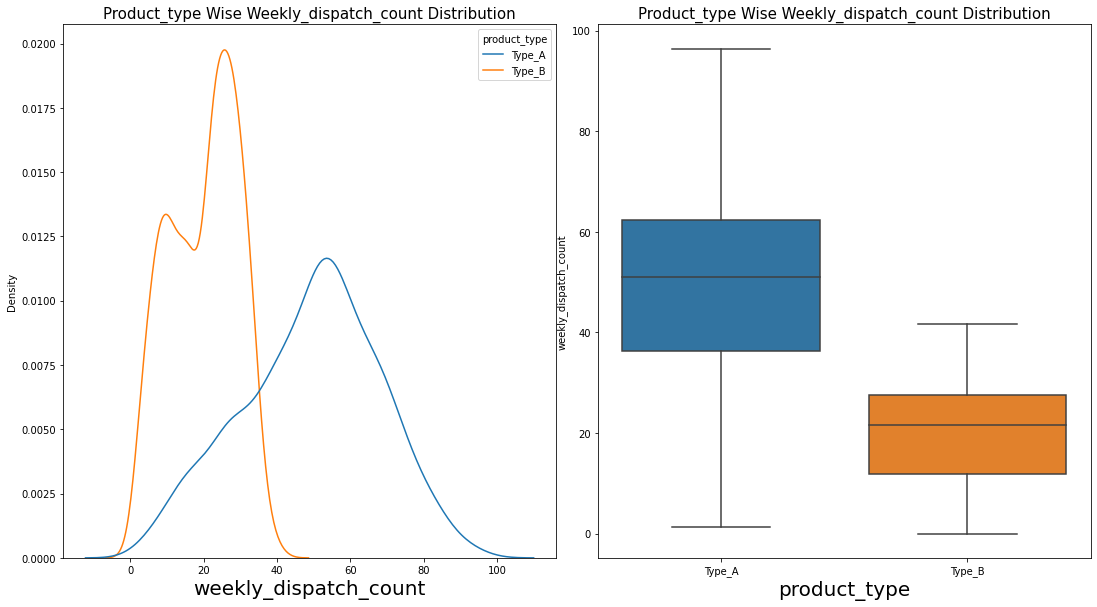

In [ ]:
side_by_side_plot(train,'product_type','weekly_dispatch_count')

In [ ]:
group_summary(train,'product_type','weekly_dispatch_count')

,product_type,count,mean,std,min,25%,50%,75%,max
0,Type_A,1239.0,49.182002,18.801613,1.3,36.4,51.1,62.3,96.4
1,Type_B,1133.0,19.980936,9.337460,0.0,11.8,21.6,27.6,41.7


#### The above plot explains that there is a difference in the weekly dispatch count between the products.

#### Let's see whether the warehouse is closed and see the weekly dispatch count distribution.

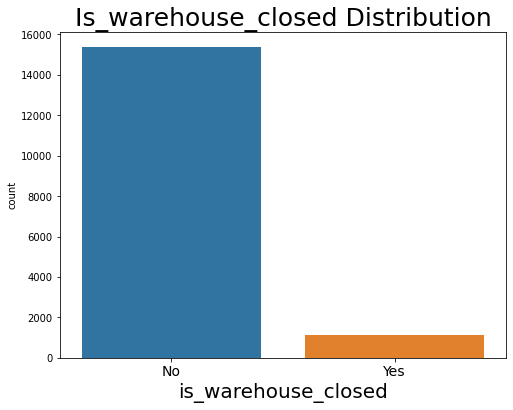

In [ ]:
count_plot(train,'is_warehouse_closed')

In [ ]:
train['is_warehouse_closed'].value_counts()

No     15365
Yes     1113
Name: is_warehouse_closed, dtype: int64

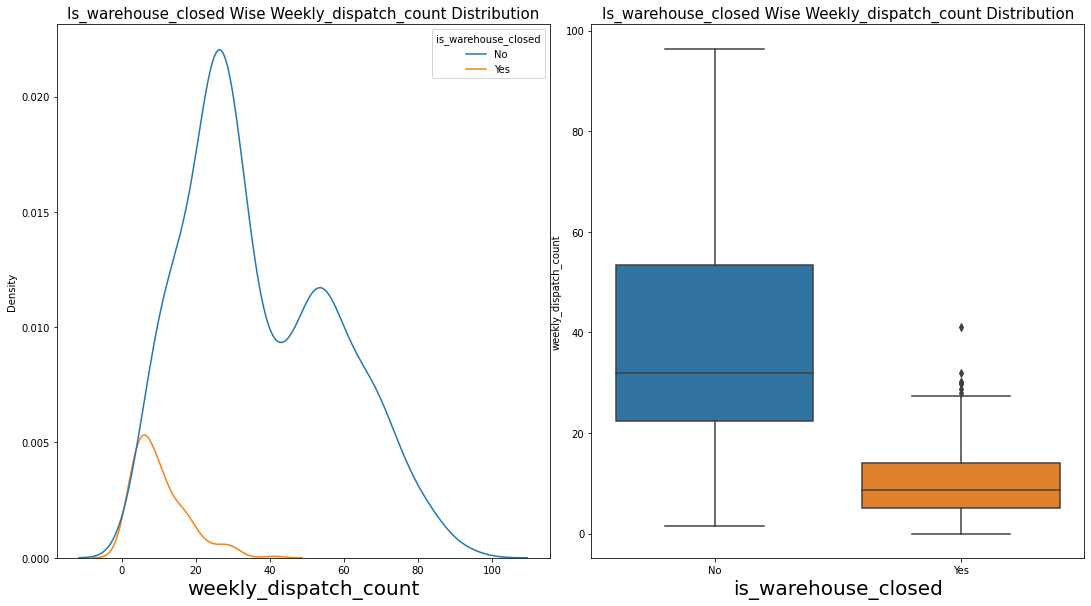

In [ ]:
side_by_side_plot(train,'is_warehouse_closed','weekly_dispatch_count')

In [ ]:
group_summary(train,'is_warehouse_closed','weekly_dispatch_count')

,is_warehouse_closed,count,mean,std,min,25%,50%,75%,max
0,No,2163.0,37.401896,20.292202,1.6,22.35,31.90,53.35,96.4
1,Yes,190.0,10.350000,7.300335,0.0,5.00,8.65,14.05,41.0


#### The above plot explains that there is a difference in the weekly dispatch count between the warehouses open/closed status.

#### Let's do some feature engineering on date column.

In [7]:
def pre_process(df):

  df['date_time']=pd.to_datetime(df["date"].astype('str')) #convert to date-time format
  df['day']=df['date_time'].dt.day #extract day from the date
  df['day_label']=df['date_time'].dt.day_name() #extract the day name from the date
  df['day_number']=df['date_time'].dt.dayofweek #extract the day number from the date
  df['month_number']=df['date_time'].dt.month #extract month number from the date
  df['month_label']=df['date_time'].dt.strftime('%b') #extract the month name from the date
  df['year_quarter']=df['date_time'].dt.quarter #extract the quarter of the year
  df['week_of_year']=df['date_time'].dt.week #extract week of the year from date
  df['year']= df['date_time'].dt.year #extract year
  df['dayofmonth'] = df['date_time'].dt.daysinmonth #extract the day of the month
  df['dayofyear'] = df['date_time'].dt.day_of_year #extract day of the year
  df['weekday']=df['date_time'].dt.day_name().isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']).astype('int') #create weekday column
  df['weekend']=df['date_time'].dt.day_name().isin(['Saturday', 'Sunday']).astype('int') #create weekend column
  df['month_start']=df['date_time'].dt.is_month_start.astype('int') #create month start
  df['month_end']=df['date_time'].dt.is_month_end.astype('int') #create month end
  df['quarter_start']=df['date_time'].dt.is_quarter_start.astype('int') #create quarter start
  df['quarter_end']=df['date_time'].dt.is_quarter_end.astype('int') #create quarter end
  df['year_start']=df['date_time'].dt.is_year_start.astype('int') #create year start
  df['year_end']=df['date_time'].dt.is_year_end.astype('int') #create year end
 
  #function to convert month to seasons
  def month2seasons(x):
    season=""
    if x in [12, 1, 2]:
        season = 'winter'
    elif x in [3, 4, 5]:
        season = 'spring'
    elif x in [6, 7, 8]:
        season = 'summer'
    elif x in [9,10, 11]:
        season = 'autumn'
    return season

 
  df['seasons']=df['month_number'].apply(month2seasons)

  return df

### Apply the feature_engineering steps to date column.

In [8]:
train=pre_process(train)

### Let's see how the weekly dispatch count changes over the year.

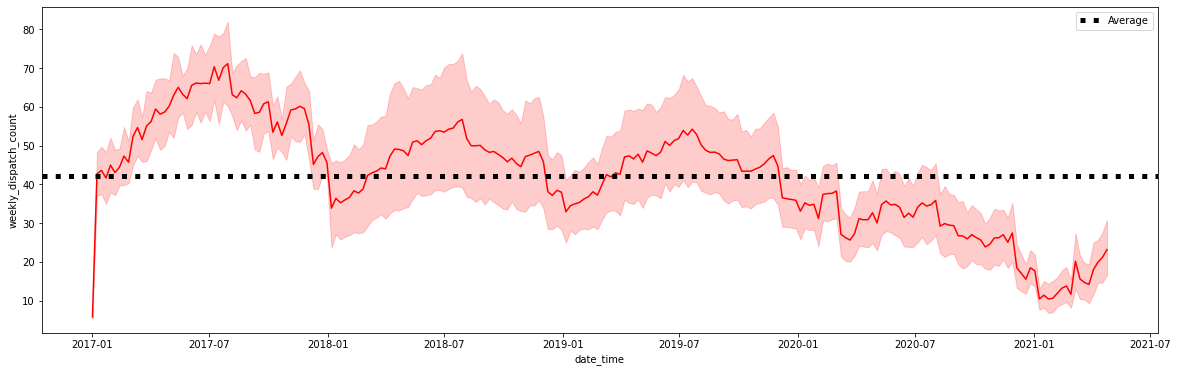

In [ ]:
plt.figure(figsize=(20,6))
yr=sns.lineplot(x=train['date_time'],y=train['weekly_dispatch_count'],color="Red")
yr.axhline(train.groupby('date_time')['weekly_dispatch_count'].agg({'mean'}).mean()[0],
          ls=":",color="Black",lw=5,label='Average');
plt.legend();          

#### After 2019 the weekly dispatch count is very lower than the yearly average weekly dispatch count(40).

### Let's see how the daily dispatch count changes over the year.

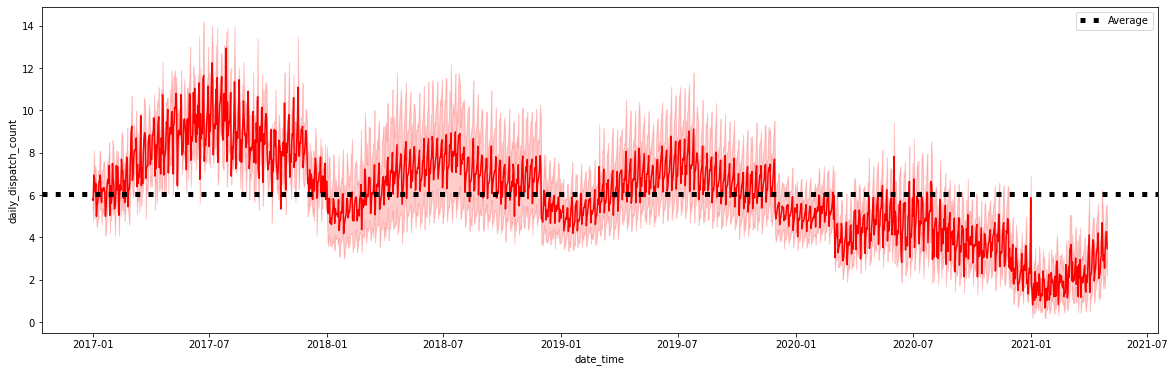

In [ ]:
plt.figure(figsize=(20,6))
yr=sns.lineplot(x=train['date_time'],y=train['daily_dispatch_count'],color="Red")
yr.axhline(train.groupby('date_time')['daily_dispatch_count'].agg({'mean'}).mean()[0],
          ls=":",color="Black",lw=5,label='Average');
plt.legend();          

#### After 2019 the daily dispatch count is very lower than the yearly average daily dispatch count(6).

### Let's see how the weekly dispatch count changes over 12 months.

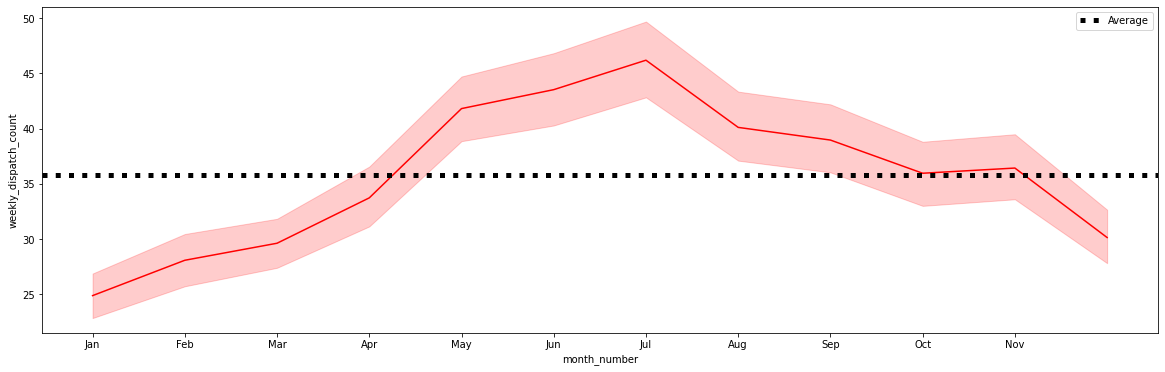

In [ ]:
plt.figure(figsize=(20,6))
mon=sns.lineplot(x=train['month_number'],y=train['weekly_dispatch_count'],color="Red")
mon.axhline(train.groupby('month_number')['weekly_dispatch_count'].agg({'mean'}).mean()[0],
          ls=":",color="Black",lw=5,label='Average');
plt.xticks(range(1,12),train['month_label'].unique());         
plt.legend();          

#### The above plot explains that from Janunary to April and after November the weekly dispatch count is lower than the monthly average  weekly dispatch count(35).

### After April to November the weekly dispatch count is higher than the monthly average  weekly dispatch count.

### Let's see how the daily dispatch count changes over 12 months.

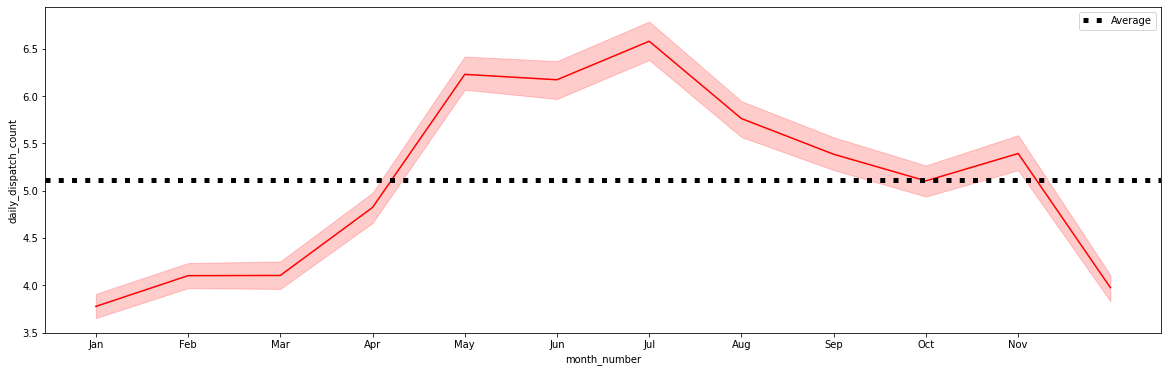

In [ ]:
plt.figure(figsize=(20,6))
mon=sns.lineplot(x=train['month_number'],y=train['daily_dispatch_count'],color="Red")
mon.axhline(train.groupby('month_number')['daily_dispatch_count'].agg({'mean'}).mean()[0],
          ls=":",color="Black",lw=5,label='Average');
plt.xticks(range(1,12),train['month_label'].unique());        
plt.legend();          

#### The above plot explains that from Janunary to April and after November the daily dispatch count is lower than the monthly average  daily dispatch count(5).

### After April to November the daily dispatch count is higher than the monthly average  daily dispatch count.

### Let's see how the weekly dispatch count changes over 52 weeks of the year.

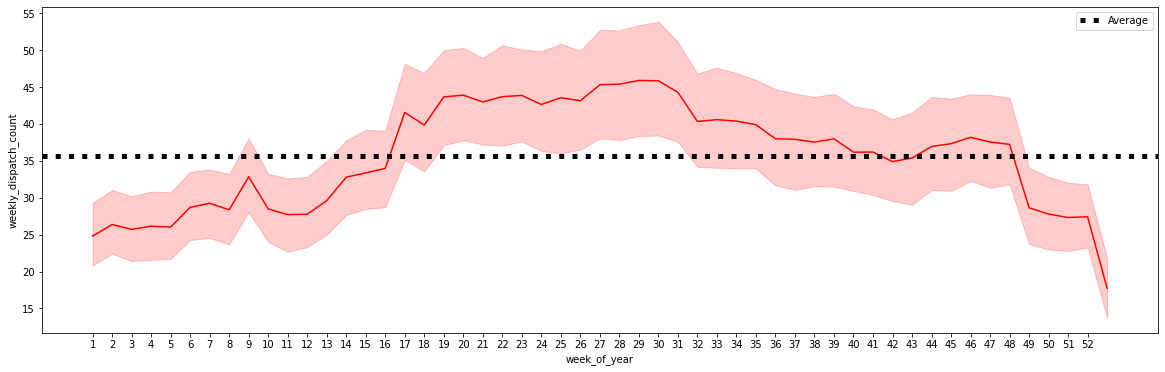

In [ ]:
plt.figure(figsize=(20,6))
wk=sns.lineplot(x=train['week_of_year'],y=train['weekly_dispatch_count'],color="Red")
wk.axhline(train.groupby('week_of_year')['weekly_dispatch_count'].agg({'mean'}).mean()[0],
          ls=":",color="Black",lw=5,label='Average');
plt.xticks(range(1,53));         
plt.legend();          

#### The above plot explains that from the week 1 to week 15 and the week 42,43, 48 to week 52 the weekly dispatch count is lower than the monthly average  weekly dispatch count(35).

### After the week 15 to week 41 the weekly dispatch count is higher than the monthly average  weekly dispatch count.



### Let's see how the daily dispatch count changes over 52 weeks of the year.

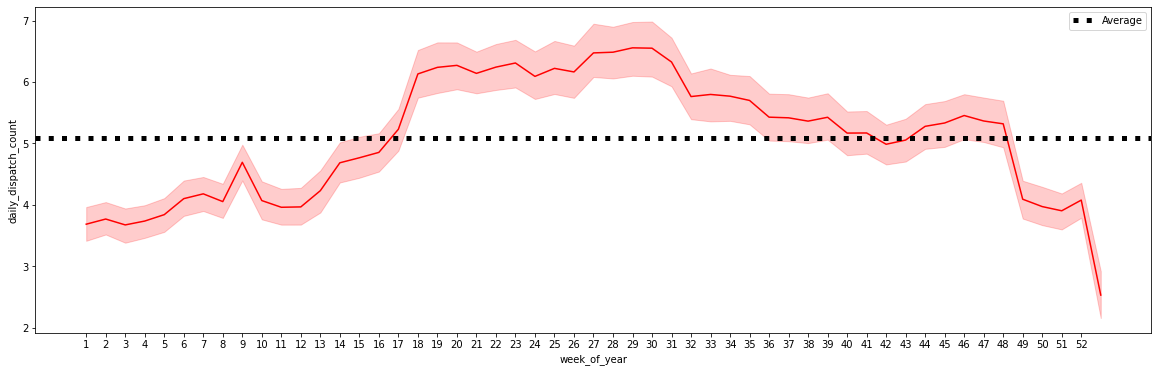

In [ ]:
plt.figure(figsize=(20,6))
wk=sns.lineplot(x=train['week_of_year'],y=train['daily_dispatch_count'],color="Red")
wk.axhline(train.groupby('week_of_year')['daily_dispatch_count'].agg({'mean'}).mean()[0],
          ls=":",color="Black",lw=5,label='Average');
plt.xticks(range(1,53));         
plt.legend();          

#### The above plot explains that from the week 1 to week 15 and the week 42,43, 48 to 52 the daily dispatch count is lower than the monthly average daily dispatch count(5).

### After the week 15 to week 41 the daily dispatch count is higher than the monthly average  daily dispatch count.



### Let's see product wise weekly dispatch count over the year.

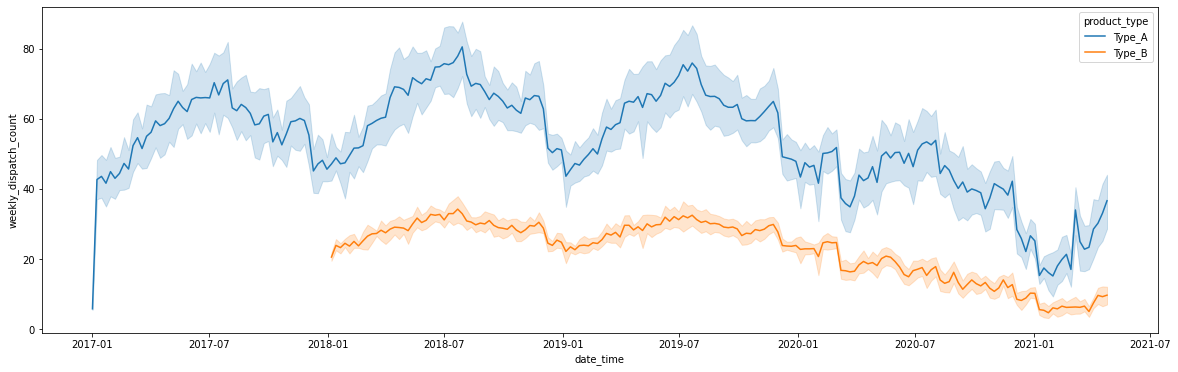

In [ ]:
plt.figure(figsize=(20,6))
sns.lineplot(x=train['date_time'],y=train['weekly_dispatch_count'],color="Red",hue=train['product_type'])       

### Let's see product wise daily dispatch count over the year.

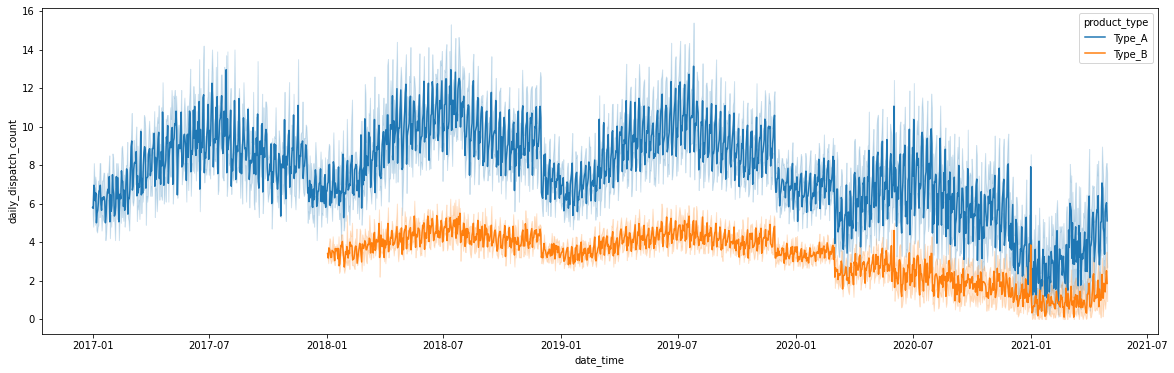

In [ ]:
plt.figure(figsize=(20,6))
sns.lineplot(x=train['date_time'],y=train['daily_dispatch_count'],color="Red",hue=train['product_type'])       

### Let's see product wise weekly dispatch count over the 12 months.

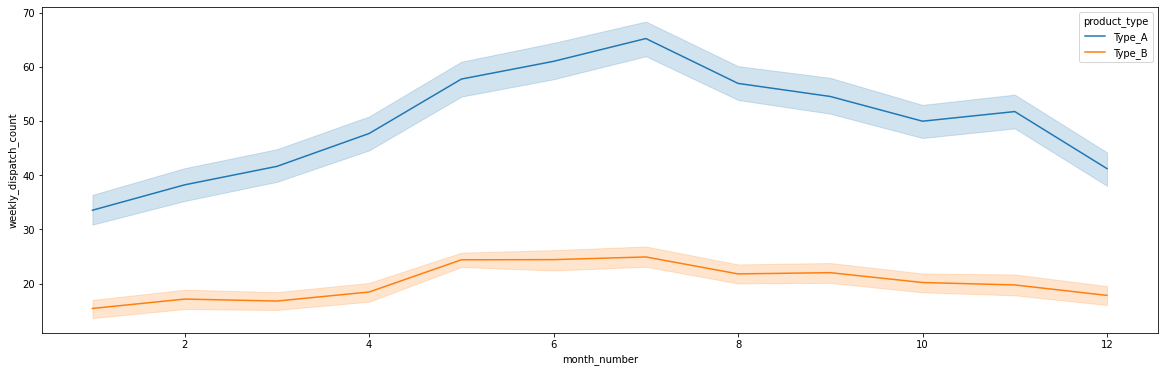

In [ ]:
plt.figure(figsize=(20,6))
sns.lineplot(x=train['month_number'],y=train['weekly_dispatch_count'],color="Red",hue=train['product_type'])       

### Let's see product wise daily dispatch count over the 12 months.

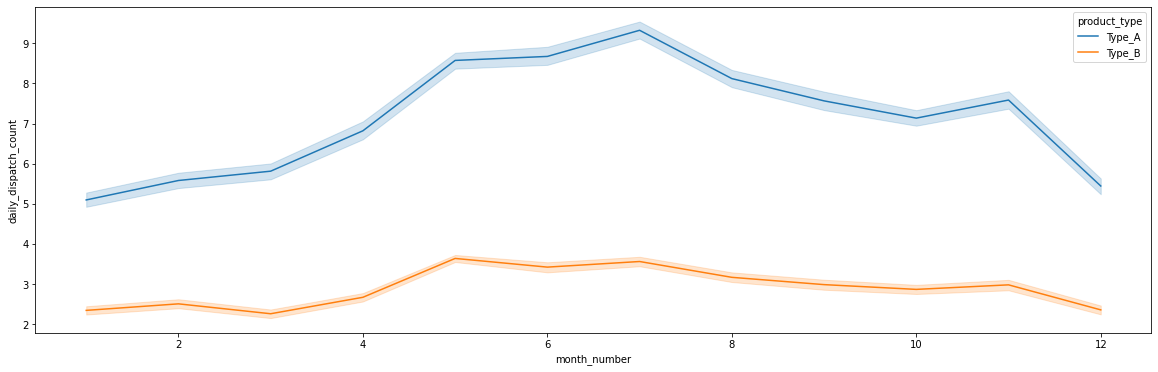

In [ ]:
plt.figure(figsize=(20,6))
sns.lineplot(x=train['month_number'],y=train['daily_dispatch_count'],color="Red",hue=train['product_type'])       

### Let's see product wise weekly dispatch count over the 52 weeks.

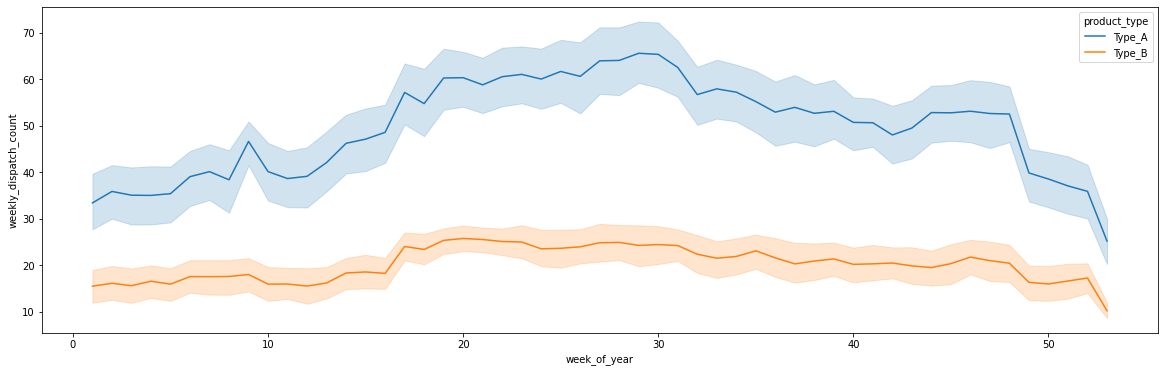

In [ ]:
plt.figure(figsize=(20,6))
sns.lineplot(x=train['week_of_year'],y=train['weekly_dispatch_count'],color="Red",hue=train['product_type'])       

### Let's see product wise daily dispatch count over the 52 weeks.

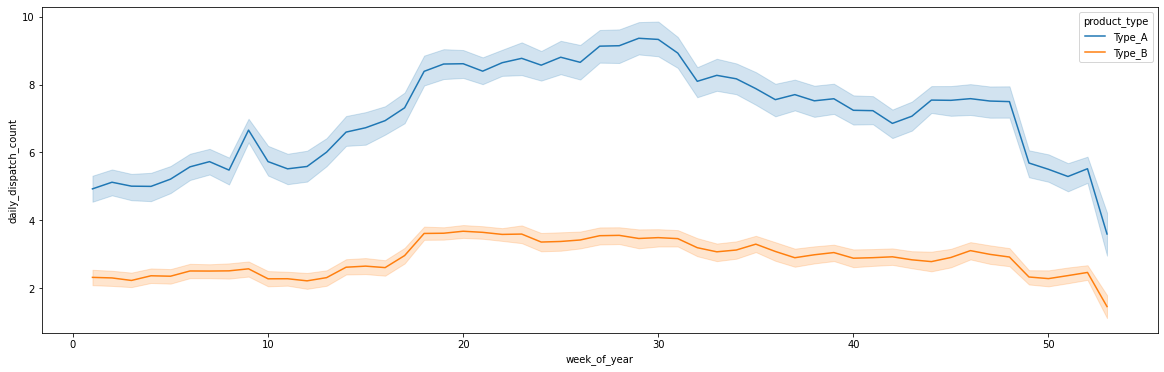

In [ ]:
plt.figure(figsize=(20,6))
sns.lineplot(x=train['week_of_year'],y=train['daily_dispatch_count'],color="Red",hue=train['product_type'])       

### Let's see warehouse wise weekly dispatch count over the year.

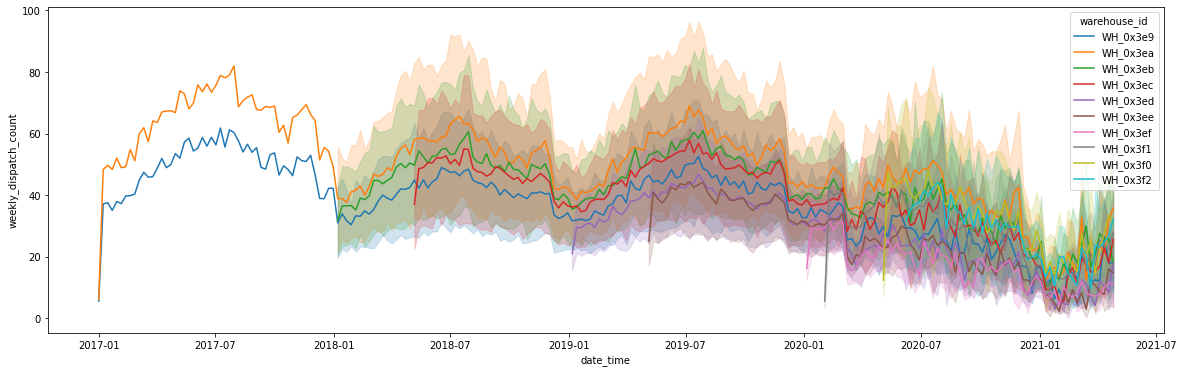

In [ ]:
plt.figure(figsize=(20,6))
sns.lineplot(x=train['date_time'],y=train['weekly_dispatch_count'],color="Red",hue=train['warehouse_id'])       

#### Over the year more number of weekly dispatches from the warehouse Wh_0x3e9.

### Let's see warehouse wise daily dispatch count over the year.

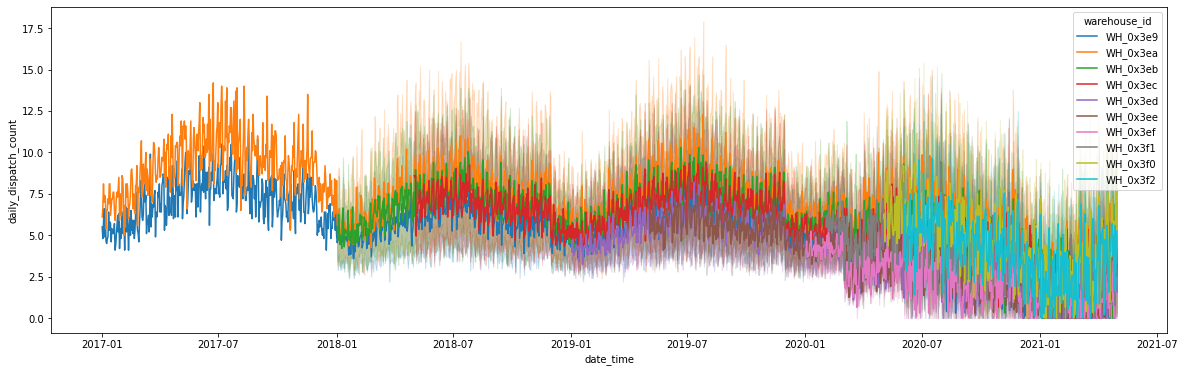

In [ ]:
plt.figure(figsize=(20,6))
sns.lineplot(x=train['date_time'],y=train['daily_dispatch_count'],color="Red",hue=train['warehouse_id'])       

### Let's see warehouse wise weekly dispatch count over the 12 months.

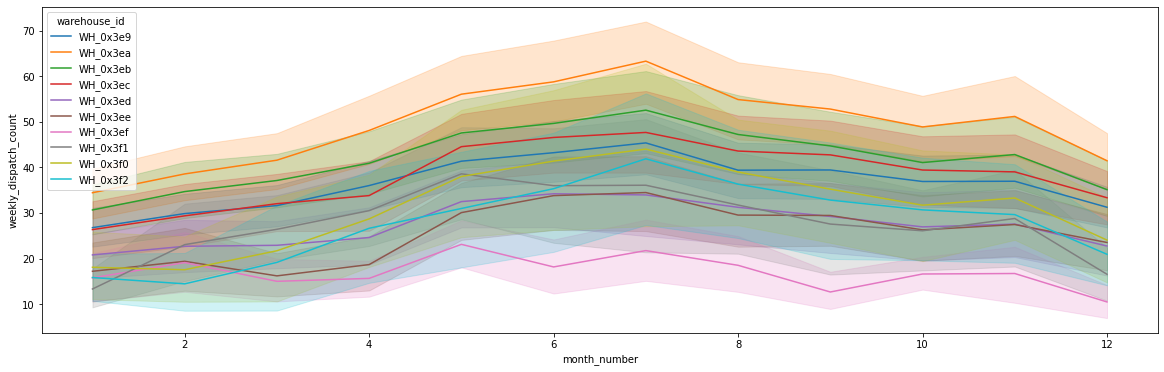

In [ ]:
plt.figure(figsize=(20,6))
sns.lineplot(x=train['month_number'],y=train['weekly_dispatch_count'],color="Red",hue=train['warehouse_id'])       

#### Over the 12 months more number of weekly dispatches from the warehouse Wh_0x3ea.

### Let's see warehouse wise daily dispatch count over the 12 months.

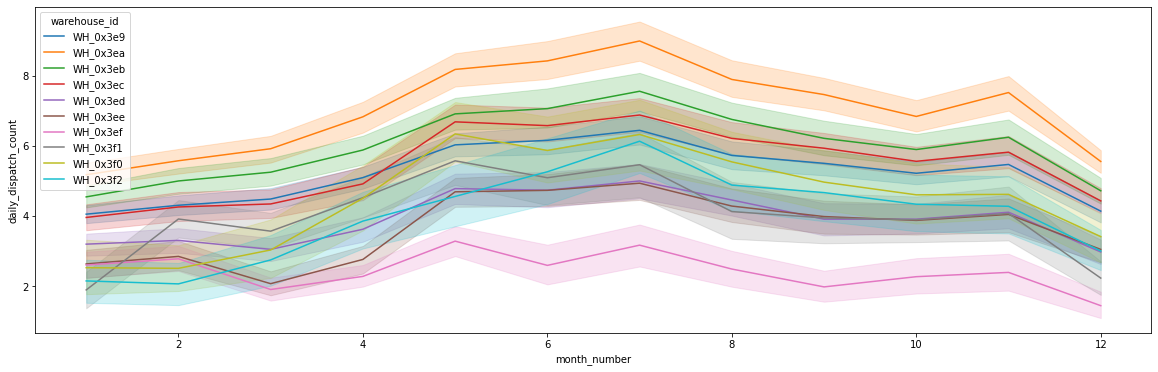

In [ ]:
plt.figure(figsize=(20,6))
sns.lineplot(x=train['month_number'],y=train['daily_dispatch_count'],color="Red",hue=train['warehouse_id'])       

### Let's see warehouse wise weekly dispatch count over the 52 weeks.

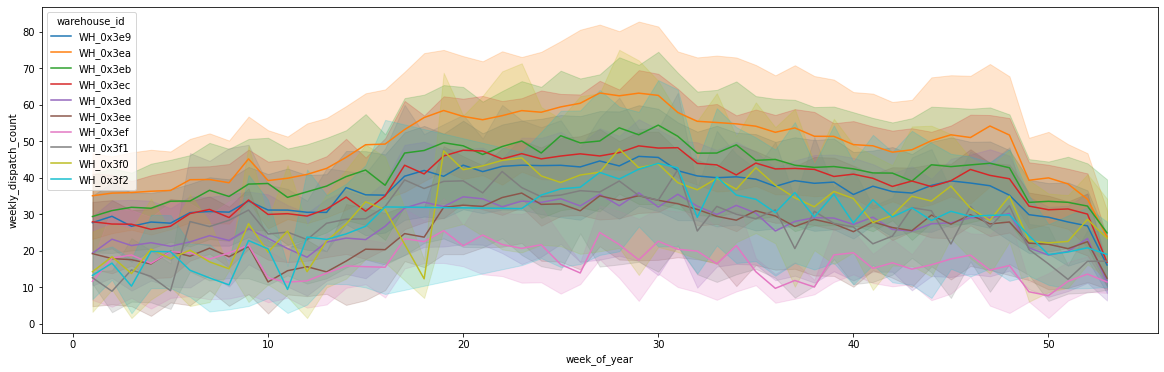

In [ ]:
plt.figure(figsize=(20,6))
sns.lineplot(x=train['week_of_year'],y=train['weekly_dispatch_count'],color="Red",hue=train['warehouse_id'])       

### Let's see warehouse wise daily dispatch count over the 52 weeks.

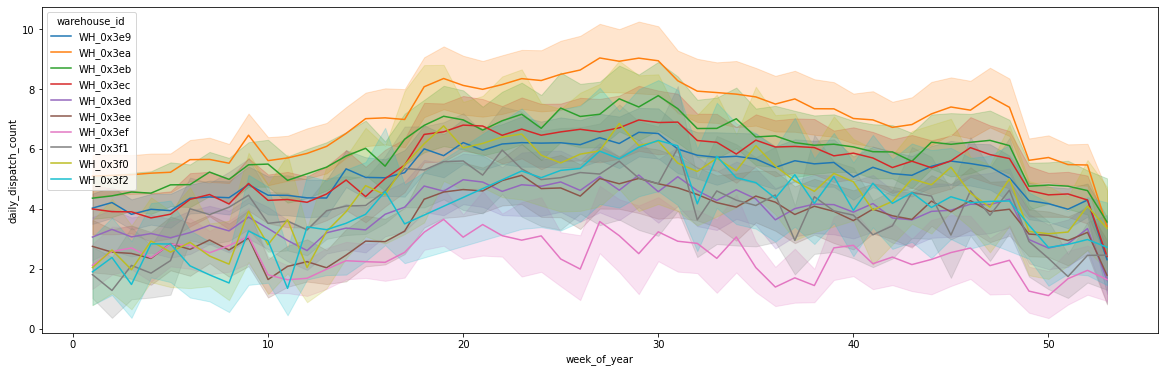

In [ ]:
plt.figure(figsize=(20,6))
sns.lineplot(x=train['week_of_year'],y=train['daily_dispatch_count'],color="Red",hue=train['warehouse_id'])       

### Let's see warehouse-wise weekly dispatch count over time with different climate seasons.

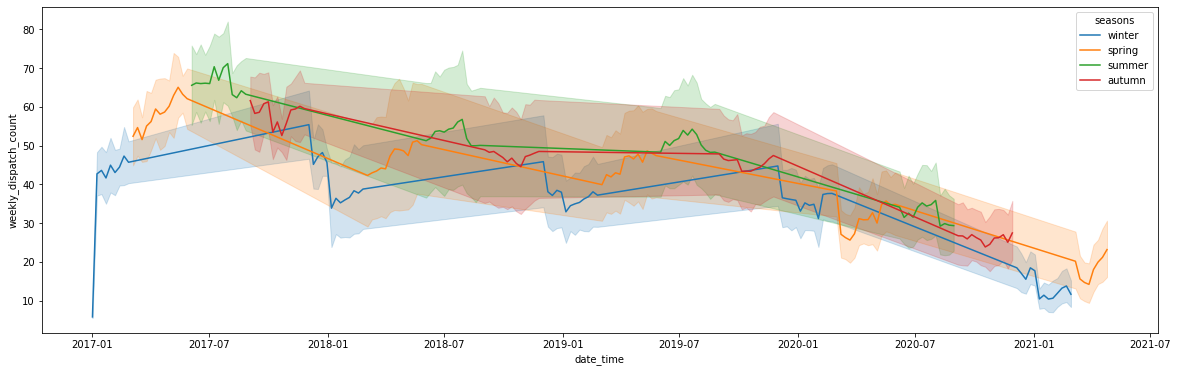

In [9]:
plt.figure(figsize=(20,6))
_=sns.lineplot(x=train['date_time'],y=train['weekly_dispatch_count'],hue=train['seasons'])       

#### Over time the weekly dispatch count gradually decreased.

#### summertime weekly dispatch count is high when compared to other seasons.

### Let's see warehouse-wise daily dispatch count over time with different climate seasons.

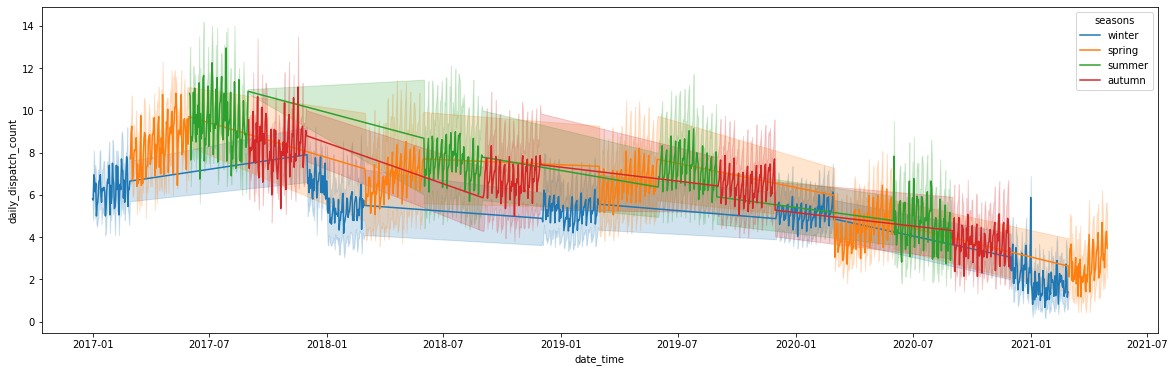

In [10]:
plt.figure(figsize=(20,6))
_=sns.lineplot(x=train['date_time'],y=train['daily_dispatch_count'],hue=train['seasons'])       

#### Over time the daily dispatch count gradually decreased.

#### summertime daily dispatch count is high when compared to other seasons.

### Let's use acf and pacf and see how values are correlated with previous value. 

In [ ]:
import statsmodels.api as sm

### ACF function

In [ ]:
def acf_plot(df,date,valcol,lag):
  plt.rc("figure", figsize=(16,8))
  x=train[[date,valcol]]
  x.set_index(date,inplace=True)
  lag_acf = sm.graphics.tsa.plot_acf(x[valcol], lags=lag)
  plt.title(valcol)  

<Figure size 1080x432 with 0 Axes>

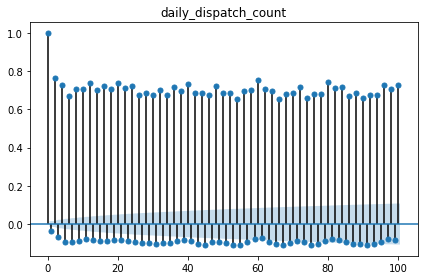

In [ ]:
acf_plot(train,'date_time','daily_dispatch_count',lag=100)

### PACF function

In [ ]:
def pacf_plot(df,date,valcol,lag):
  plt.rc("figure", figsize=(16,8))
  x=train[[date,valcol]]
  x.set_index(date,inplace=True)
  lag_pacf = sm.graphics.tsa.plot_pacf(x[valcol], lags=lag)
  plt.title(valcol)   

<Figure size 1080x432 with 0 Axes>

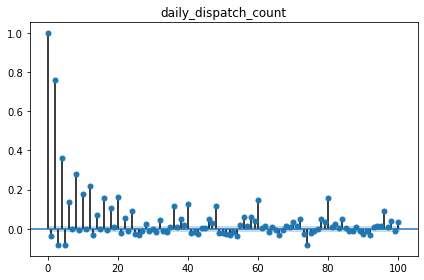

In [ ]:
pacf_plot(train,'date_time','daily_dispatch_count',lag=100)

### Let's use adfuller test to see whether the data is stationary or not.

In [ ]:
from statsmodels.tsa.stattools import adfuller

### ADF test function

In [ ]:
def adf_test(df,date,valcol):
  x=df[[date,valcol]]
  x.set_index(date,inplace=True)
  print("Observations of Dickey-fuller test")
  dftest = adfuller(x[valcol],autolag='AIC')
  dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
  for key,value in dftest[4].items():
      dfoutput['critical value (%s)'%key]= value
  print(dfoutput)

In [ ]:
adf_test(train,'date_time','daily_dispatch_count')

Observations of Dickey-fuller test
Test Statistic                    -4.573124
p-value                            0.000145
#lags used                        42.000000
number of observations used    16601.000000
critical value (1%)               -3.430744
critical value (5%)               -2.861714
critical value (10%)              -2.566863
dtype: float64


#### The above test explains that the p-value is <0.05 so reject the null hypothesis(non-stationary) and conclude data is stationary.